In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from tqdm import tqdm
import glob
import os
import re

# --- Parameters ---
num_fils = 309
num_steps = 500

# --- Find Data Files ---
# Assuming the directory structure contains matching simulation runs
no_tilt_files = sorted(glob.glob('../data/no_tilt_*/*/*true_states.dat'))
yes_tilt_files = sorted(glob.glob('../data/yes_tilt_*/*/*true_states.dat'))

# --- Load Data ---
no_tilt_data = [np.loadtxt(f) for f in tqdm(no_tilt_files, desc="Loading no_tilt data")]
yes_tilt_data = [np.loadtxt(f) for f in tqdm(yes_tilt_files, desc="Loading yes_tilt data")]

def get_params_from_path(file_path):
    """Extracts parameters from the file path using regex."""
    # Adjusted regex to be more robust
    match = re.search(
        r'([a-zA-Z_]+)_([0-9\.]+)_([a-zA-Z_]+)_([0-9\.]+)', os.path.dirname(file_path)
    )
    params = {}
    if match:
        params[match.group(1)] = float(match.group(2))
        params[match.group(3)] = float(match.group(4))
    return params

Loading yes_tilt data: 100%|██████████| 2/2 [00:00<00:00, 49.99it/s]


In [3]:
# --- Process Data ---
def process_data(data_list):
    """Processes a list of simulation data arrays."""
    times = []
    phases_list = []
    for data in data_list:
        time = data[:, 0] / num_steps
        phases = np.mod(data[:, 2:num_fils+2], 2*np.pi)
        times.append(time)
        phases_list.append(phases)
    return times, phases_list

no_tilt_times, no_tilt_phases = process_data(no_tilt_data)
yes_tilt_times, yes_tilt_phases = process_data(yes_tilt_data)

# Find the maximum time for consistent x-axis scaling
all_times = no_tilt_times + yes_tilt_times
max_time = 0
if all_times:
    max_time = max(t.max() for t in all_times if t.size > 0)

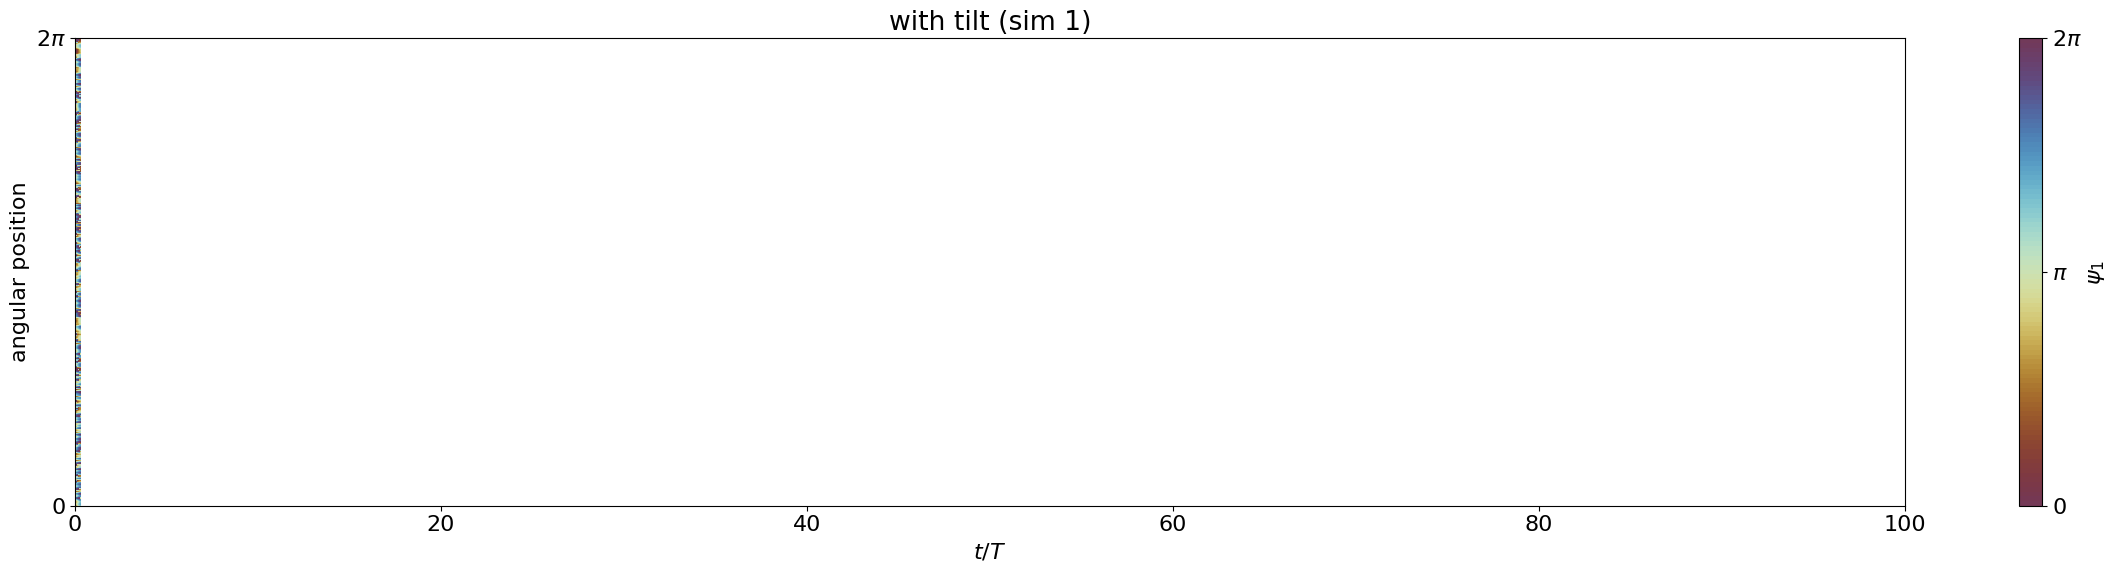

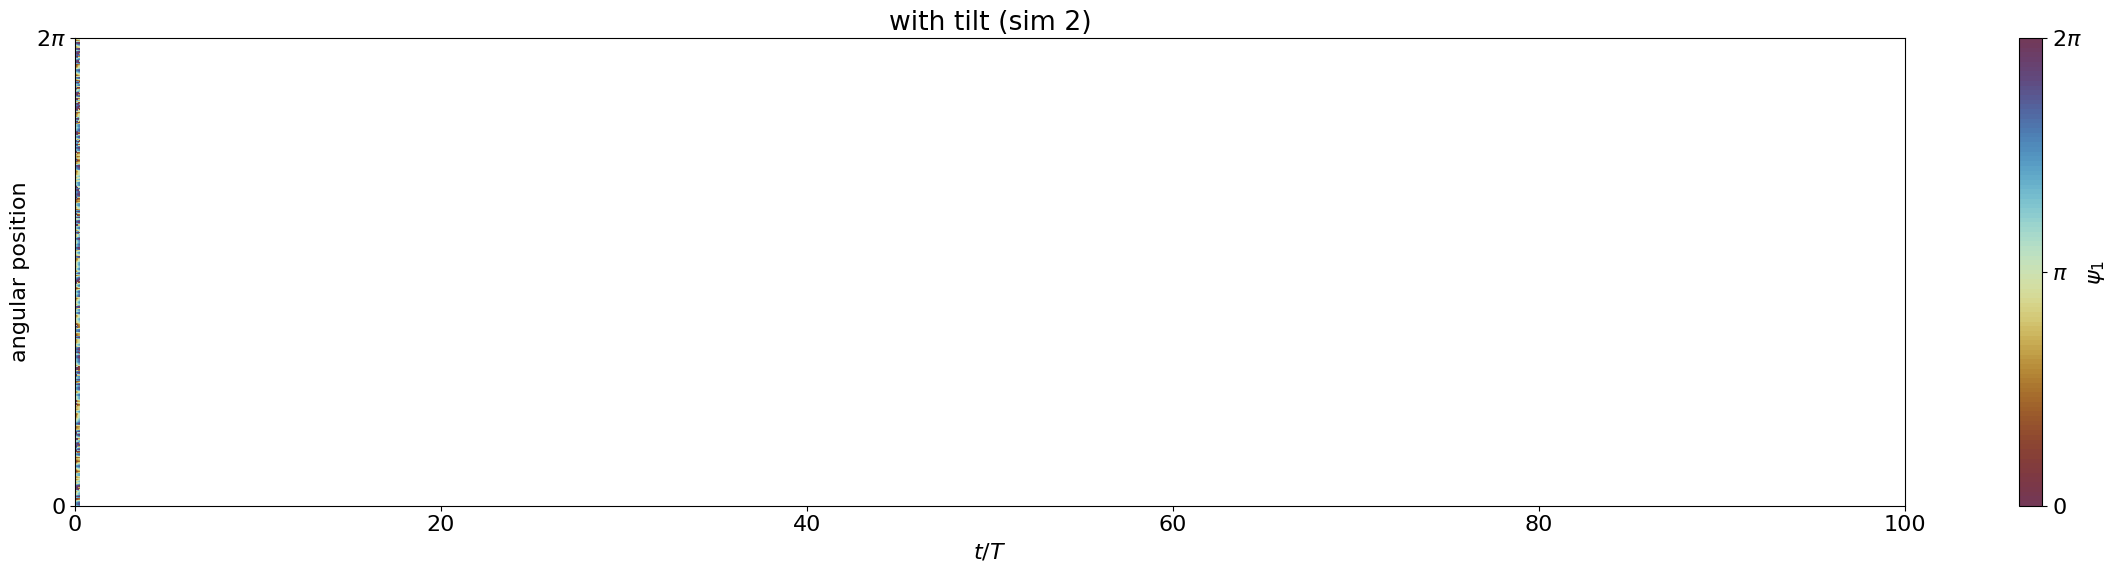

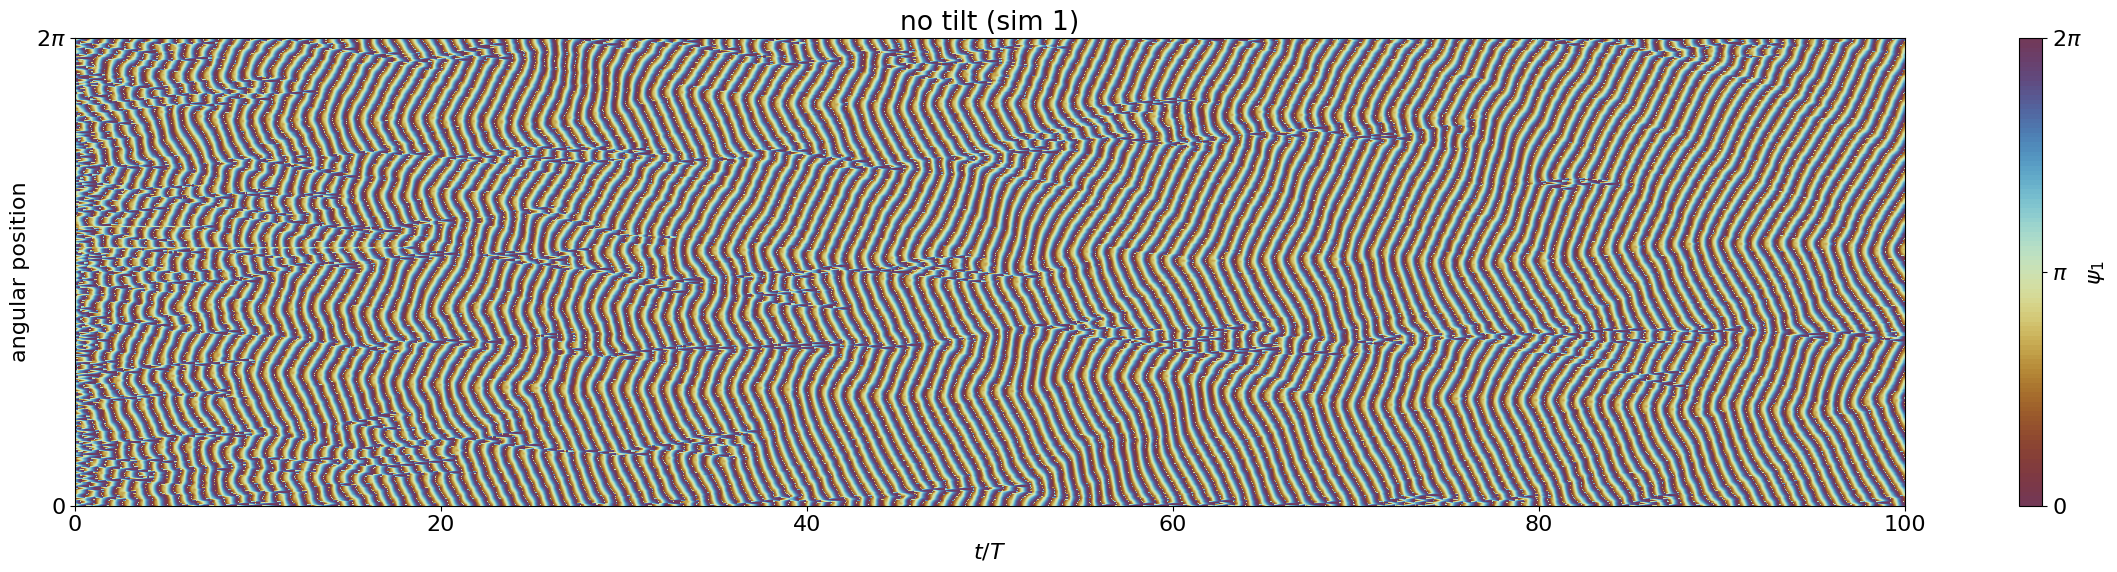

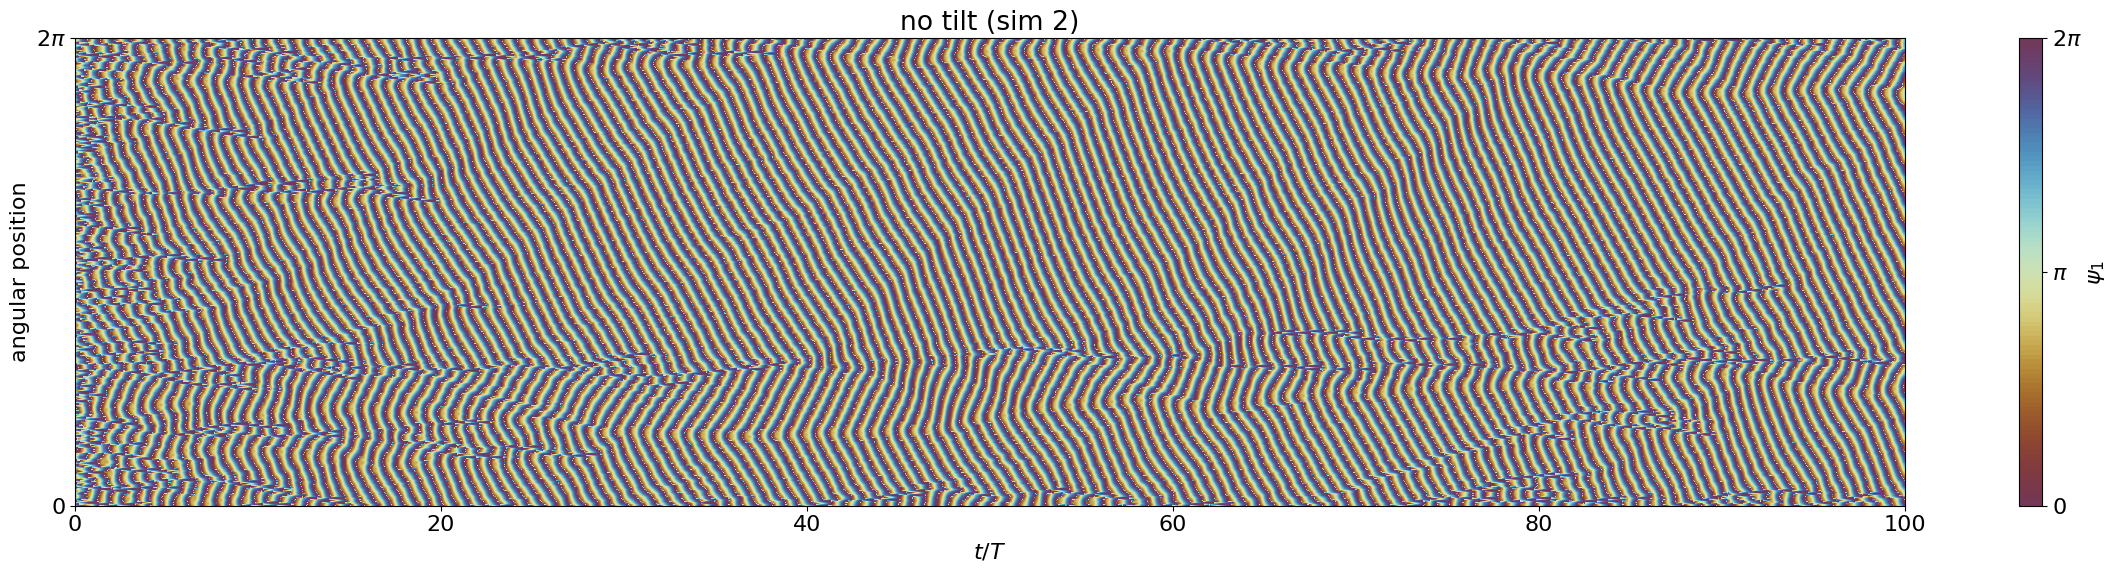

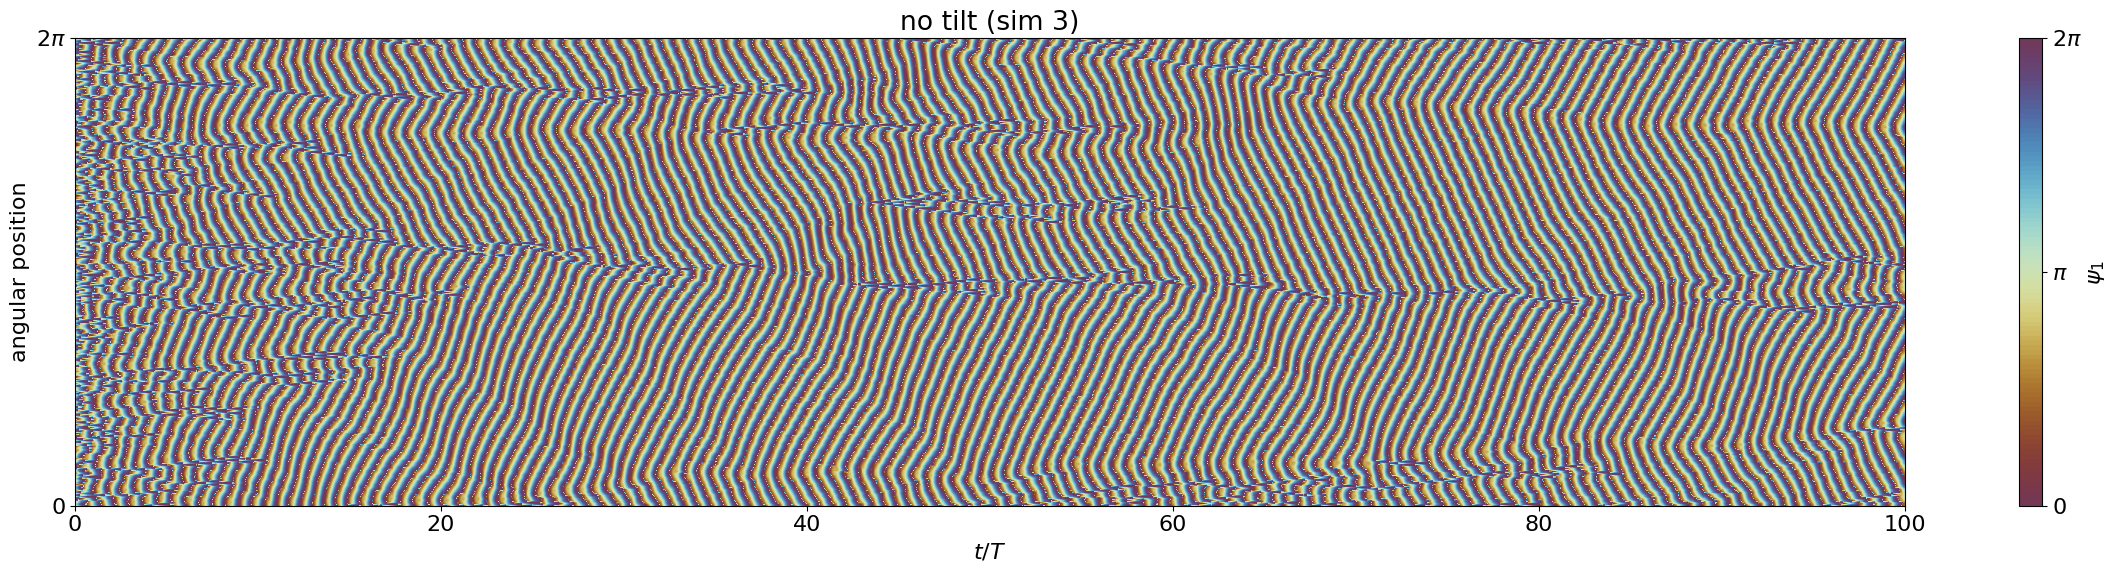

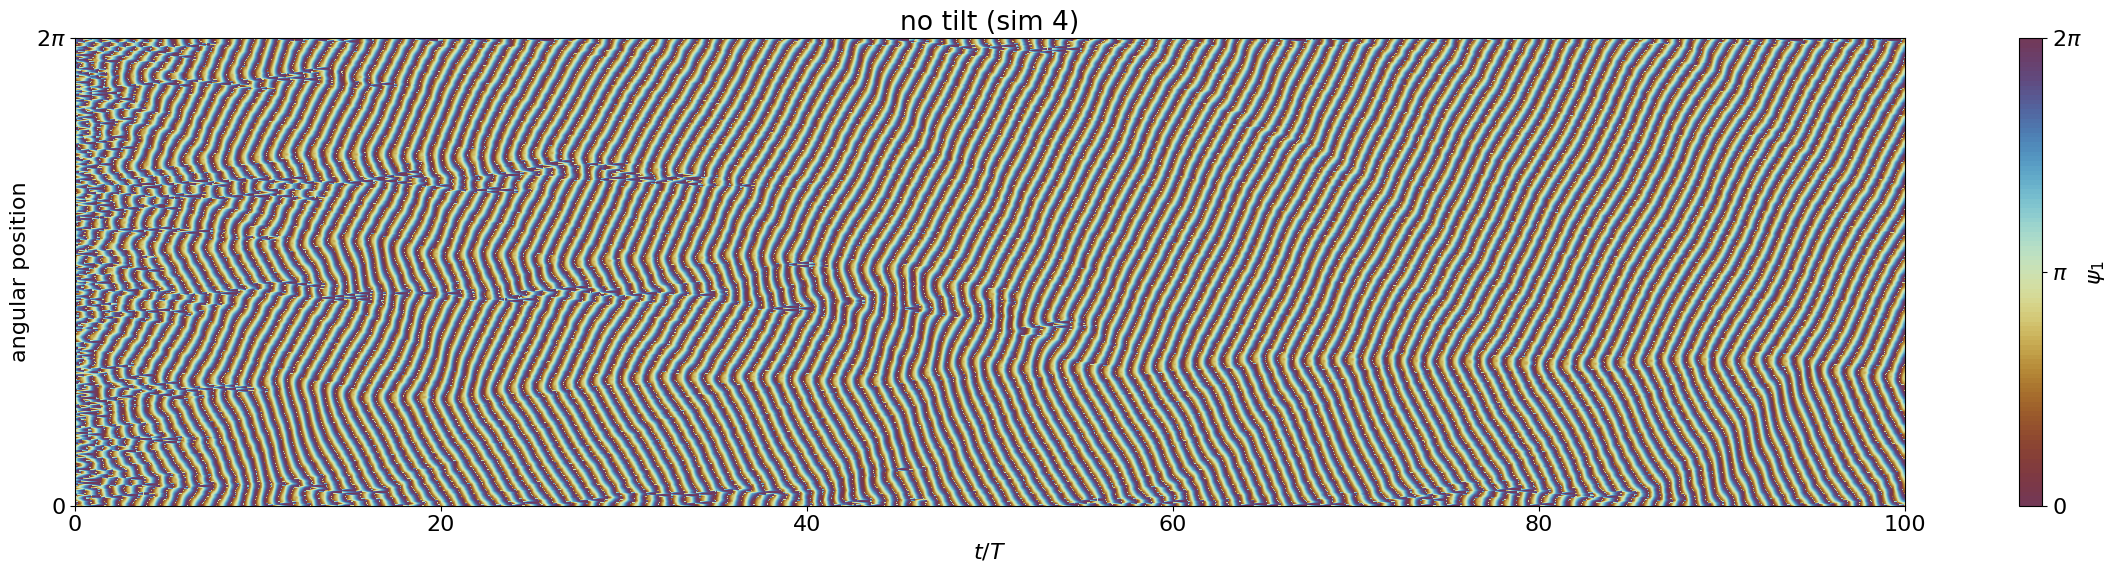

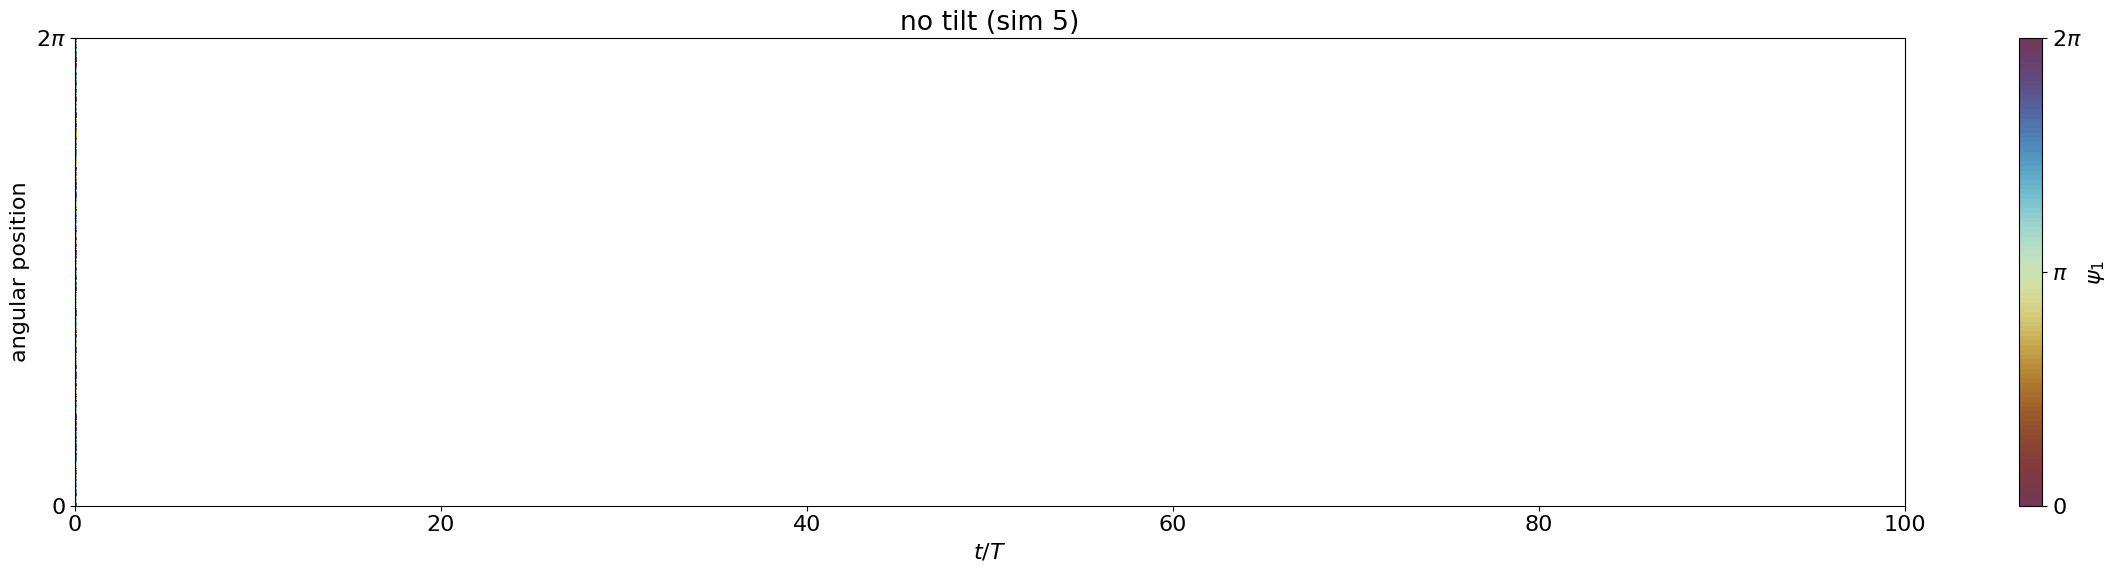

In [4]:
# --- Create Kymograph Plots ---
num_yes = len(yes_tilt_files)
num_no = len(no_tilt_files)
total_sims = num_yes + num_no

if total_sims == 0:
    print("No simulation files found.")
else:
    plt.rcParams.update({"font.size": 16})

    # Plotting function
    def plot_kymograph(time, phases, title):
        fig, ax = plt.subplots(figsize=(24, 6))
        position = np.linspace(0, 2*np.pi, num_fils)
        xx, yy = np.meshgrid(time, position)
        im = ax.contourf(
            xx, yy, phases.T, cmap=cmc.romaO, levels=np.linspace(0, 2*np.pi, 100)
        )
        
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(r'$\psi_1$')
        cbar.set_ticks([0, np.pi, 2*np.pi])
        cbar.set_ticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
        
        ax.set_xlabel(r'$t/T$')
        ax.set_ylabel('angular position')
        ax.set_title(title)
        ax.set_yticks([0, 2*np.pi])
        ax.set_yticklabels([r'$0$', r'$2\pi$'])
        if max_time > 0:
            ax.set_xlim(0, max_time)
        
        plt.tight_layout()
        plt.show()

    # Plot all 'with tilt' simulations
    for i in range(num_yes):
        params = get_params_from_path(yes_tilt_files[i])
        title = f'with tilt (sim {i+1})'
        plot_kymograph(yes_tilt_times[i], yes_tilt_phases[i], title)

    # Plot all 'no tilt' simulations
    for i in range(num_no):
        params = get_params_from_path(no_tilt_files[i])
        title = f'no tilt (sim {i+1})'
        plot_kymograph(no_tilt_times[i], no_tilt_phases[i], title)

    plt.rcParams.update(plt.rcParamsDefault)

In [8]:
# --- Wave Direction Analysis ---

def analyze_wave_direction(phases, time, num_fils):
    """
    Analyzes the direction of wave propagation using the gradient method.
    
    Args:
        phases (np.array): Array of phase data (timesteps, num_fils).
        time (np.array): Array of time points.
        num_fils (int): Number of filaments.
        
    Returns:
        tuple: Percentages of positive, negative, and stationary wave coverage.
    """
    # Use the last period of the simulation for analysis
    start_index = len(time) - num_steps
        
    phases_final = phases[start_index:, :]
    
    # We want to find the wave directions, which is equivalent to the sign of the implicit
    # dy/dt derivative in a level set of the phase function. That is,
    # psi(y, t) = constant <-> dpsi = dpsi/dt * dt + dpsi/dy * dy = 0
    # <-> dy/dt = - (dpsi/dt) / (dpsi/dy)
    # We compute the derivatives with respect to time and position implicitly as well to
    # handle periodicity..
    # Let f(y,t) = exp(i * psi(y,t)). Then
    # df/dt = -psi(y, t) * f(y,t) * d(psi)/dt and
    # df/dy = -psi(y, t) * f(y,t) * d(psi)/dy.
    # Then, d(psi)/dt = -df/dt / (psi(y, t) * f(y,t)) and
    # d(psi)/dy = -df/dy / (psi(y, t) * f(y,t)).
    
    psi = phases_final.T # Shape: (num_fils, num_timesteps)
    f_array = np.exp(1j * psi)  # Shape: (num_fils, num_timesteps)
    df_dy = np.gradient(f_array, axis=0)
    df_dt = np.gradient(f_array, axis=1)
    dpsi_dt = -df_dt / (f_array * psi)
    dpsi_dy = -df_dy / (f_array * psi)
    
    # Calculate velocity dy/dt = - (d_psi_dt / d_psi_dy)
    velocity = -dpsi_dt / (dpsi_dy + 1e-14)
    
    # We are interested in the average direction at each point on the equator over the final time steps.
    avg_velocity_at_pos = np.mean(velocity, axis=1)
    
    # Classify direction
    tol = 1e-6
    num_positive = np.sum(avg_velocity_at_pos > tol)
    num_negative = np.sum(avg_velocity_at_pos < -tol)
    num_stationary = num_fils - num_positive - num_negative
    
    # Calculate percentages
    percent_positive = (num_positive / num_fils) * 100
    percent_negative = (num_negative / num_fils) * 100
    percent_stationary = (num_stationary / num_fils) * 100
    
    return percent_positive, percent_negative, percent_stationary

# --- Perform and Print Analysis ---
print("--- Wave Direction Analysis Results ---\n")

if not no_tilt_files and not yes_tilt_files:
    print("No data to analyze.")
else:
    # Analyze 'with tilt' simulations
    print("--- With Tilt Simulations ---")
    for i in range(num_yes):
        params = get_params_from_path(yes_tilt_files[i])
        pos, neg, stat = analyze_wave_direction(yes_tilt_phases[i], yes_tilt_times[i], num_fils)
        print(f"Simulation {i+1} ({params}):")
        print(f"  - Positive (CCW) direction coverage: {pos:.2f}%")
        print(f"  - Negative (CW) direction coverage:  {neg:.2f}%")
        print(f"  - Stationary coverage:               {stat:.2f}%\n")

    # Analyze 'no tilt' simulations
    print("--- No Tilt Simulations ---")
    for i in range(num_no):
        params = get_params_from_path(no_tilt_files[i])
        pos, neg, stat = analyze_wave_direction(no_tilt_phases[i], no_tilt_times[i], num_fils)
        print(f"Simulation {i+1} ({params}):")
        print(f"  - Positive (CCW) direction coverage: {pos:.2f}%")
        print(f"  - Negative (CW) direction coverage:  {neg:.2f}%")
        print(f"  - Stationary coverage:               {stat:.2f}%\n")

--- Wave Direction Analysis Results ---

--- With Tilt Simulations ---
Simulation 1 ({}):
  - Positive (CCW) direction coverage: 47.57%
  - Negative (CW) direction coverage:  52.43%
  - Stationary coverage:               0.00%

Simulation 2 ({}):
  - Positive (CCW) direction coverage: 48.87%
  - Negative (CW) direction coverage:  51.13%
  - Stationary coverage:               0.00%

--- No Tilt Simulations ---
Simulation 1 ({}):
  - Positive (CCW) direction coverage: 60.52%
  - Negative (CW) direction coverage:  39.48%
  - Stationary coverage:               0.00%

Simulation 2 ({}):
  - Positive (CCW) direction coverage: 17.48%
  - Negative (CW) direction coverage:  82.52%
  - Stationary coverage:               0.00%

Simulation 3 ({}):
  - Positive (CCW) direction coverage: 52.43%
  - Negative (CW) direction coverage:  47.57%
  - Stationary coverage:               0.00%

Simulation 4 ({}):
  - Positive (CCW) direction coverage: 71.84%
  - Negative (CW) direction coverage:  28.16%
  - S